# IMDB Movie Review Classifier with Machine Learning

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re

import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_curve

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [7]:
df_reviews = df_reviews.dropna()

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47329 non-null object
title_type         47329 non-null object
primary_title      47329 non-null object
original_title     47329 non-null object
start_year         47329 non-null int64
end_year           47329 non-null object
runtime_minutes    47329 non-null object
is_adult           47329 non-null int64
genres             47329 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47329 non-null object
rating             47329 non-null int64
sp                 47329 non-null object
pos                47329 non-null int64
ds_part            47329 non-null object
idx                47329 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.5+ MB


In [8]:
df_reviews.duplicated().sum()

0

In [9]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,47329.000000,47329.000000,4.732900e+04,47329.000000,47329.000000,47329.000000
mean,1989.630882,0.001733,5.998278,2.556292e+04,5.484439,0.498933,6279.826808
std,19.600702,0.041588,1.494289,8.367004e+04,3.473083,0.500004,3605.724280
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**Conclusion**

The data contains 47331 entries and 17 columns. There were two missing values in the columns average_rating and votes. We removed these missing values. There are no duplicated rows.

## EDA

### Let's check the number of movies and reviews over years.

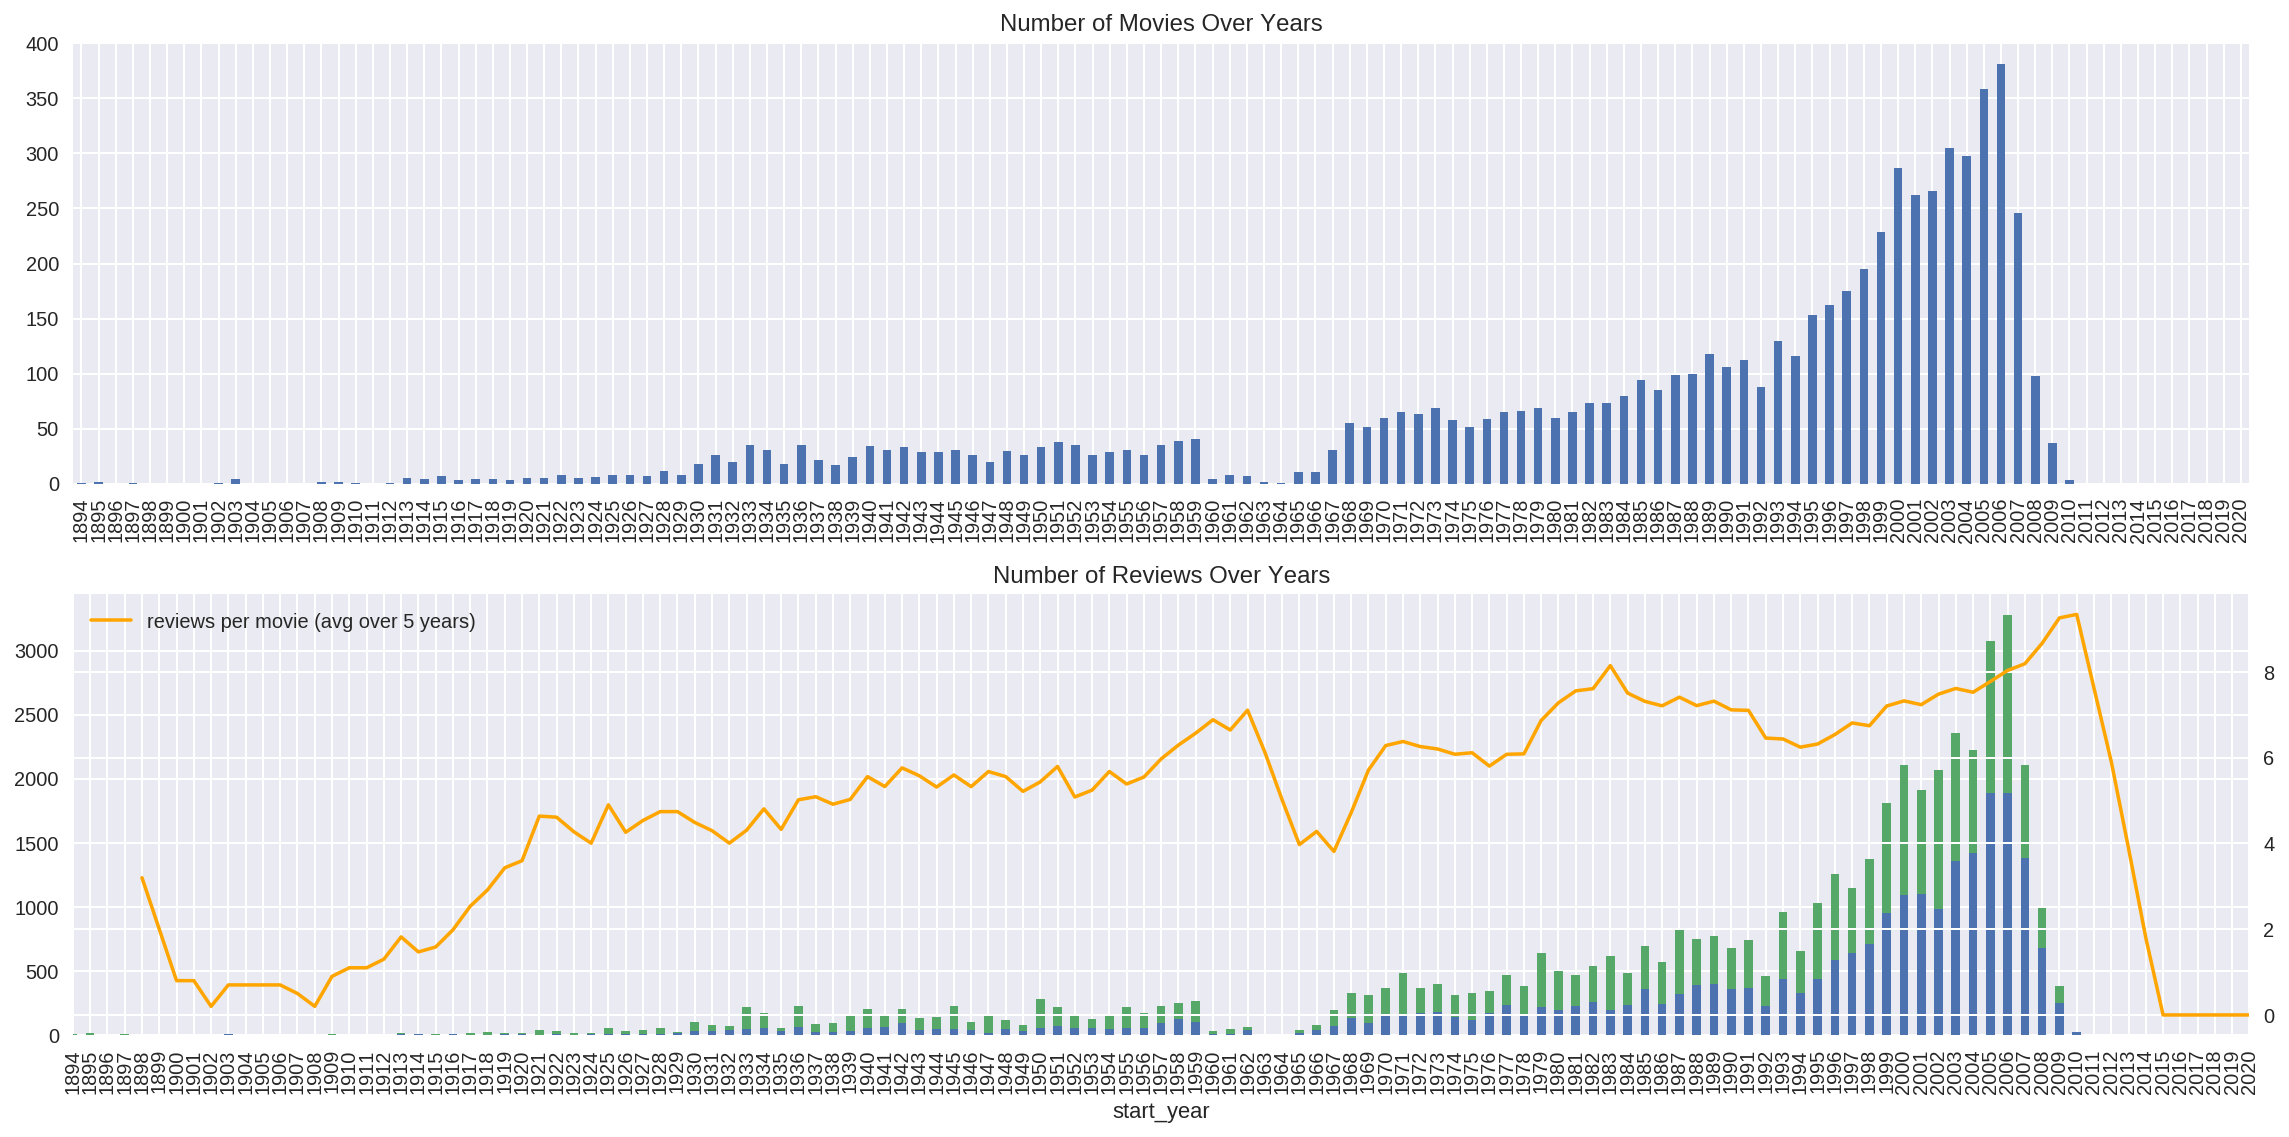

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We can see that both the number of movies and number of reviews are relatively the same over the years. Both graphs increase until 2006, then drop significantly.

### Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

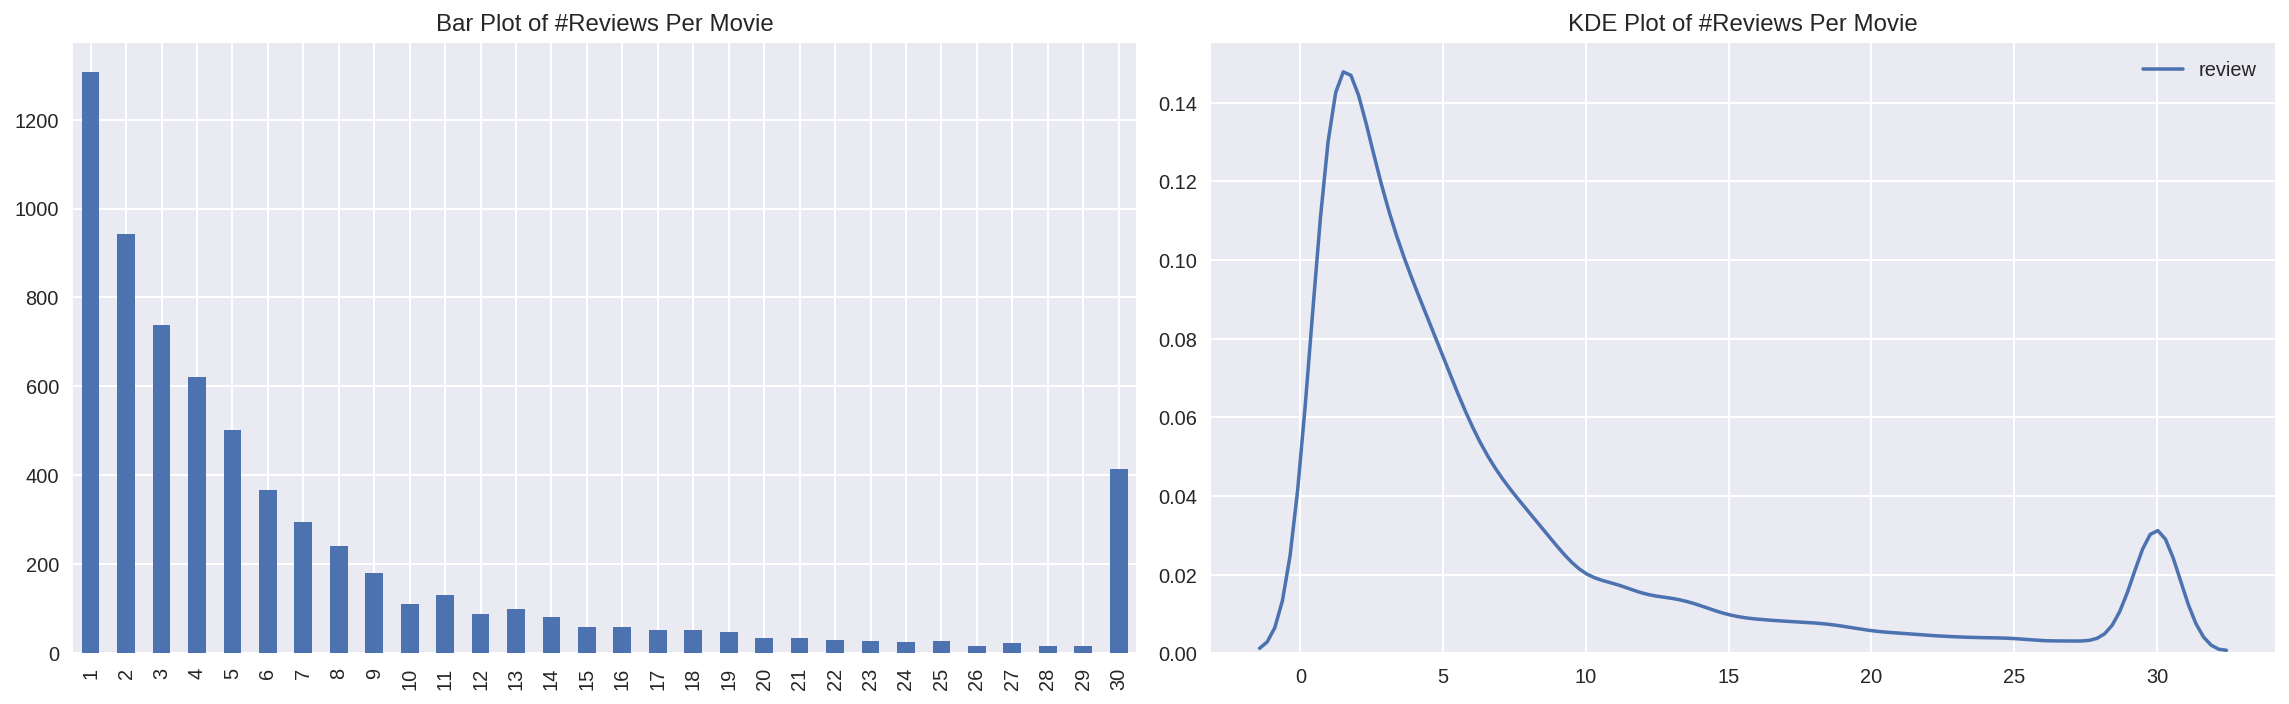

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The bar plot and KDE plot of reviews per movie are relatively the same. Movie 1 has the most, at about 1300 reviews and is 15% of the data distribution.

### The pos column contains class labels for each review. If the label is 0, then it is a negative review. If it is 1, then it is a positive review. Let's visualize and plot the distribution for the number of occurences of each label using a bar graph.

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

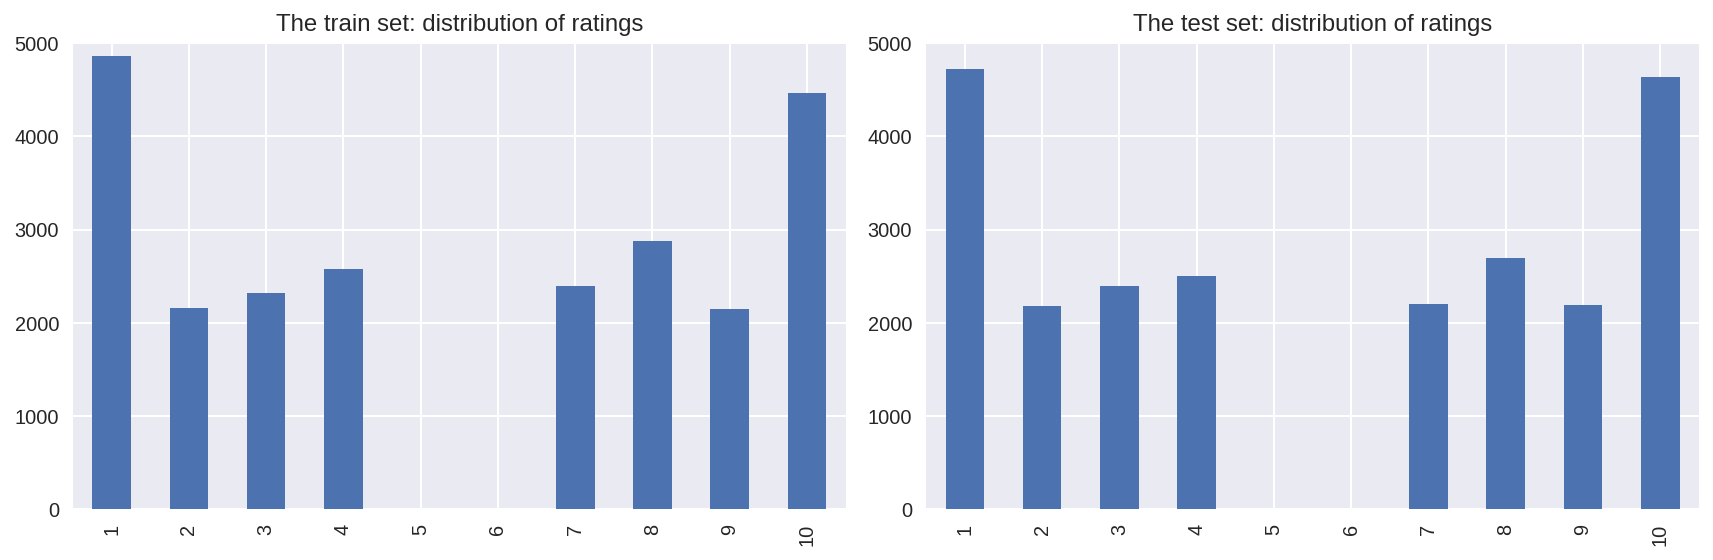

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of ratings for the train and test set are roughly the same.

### Distribution of negative and positive reviews over the years for two parts of the dataset

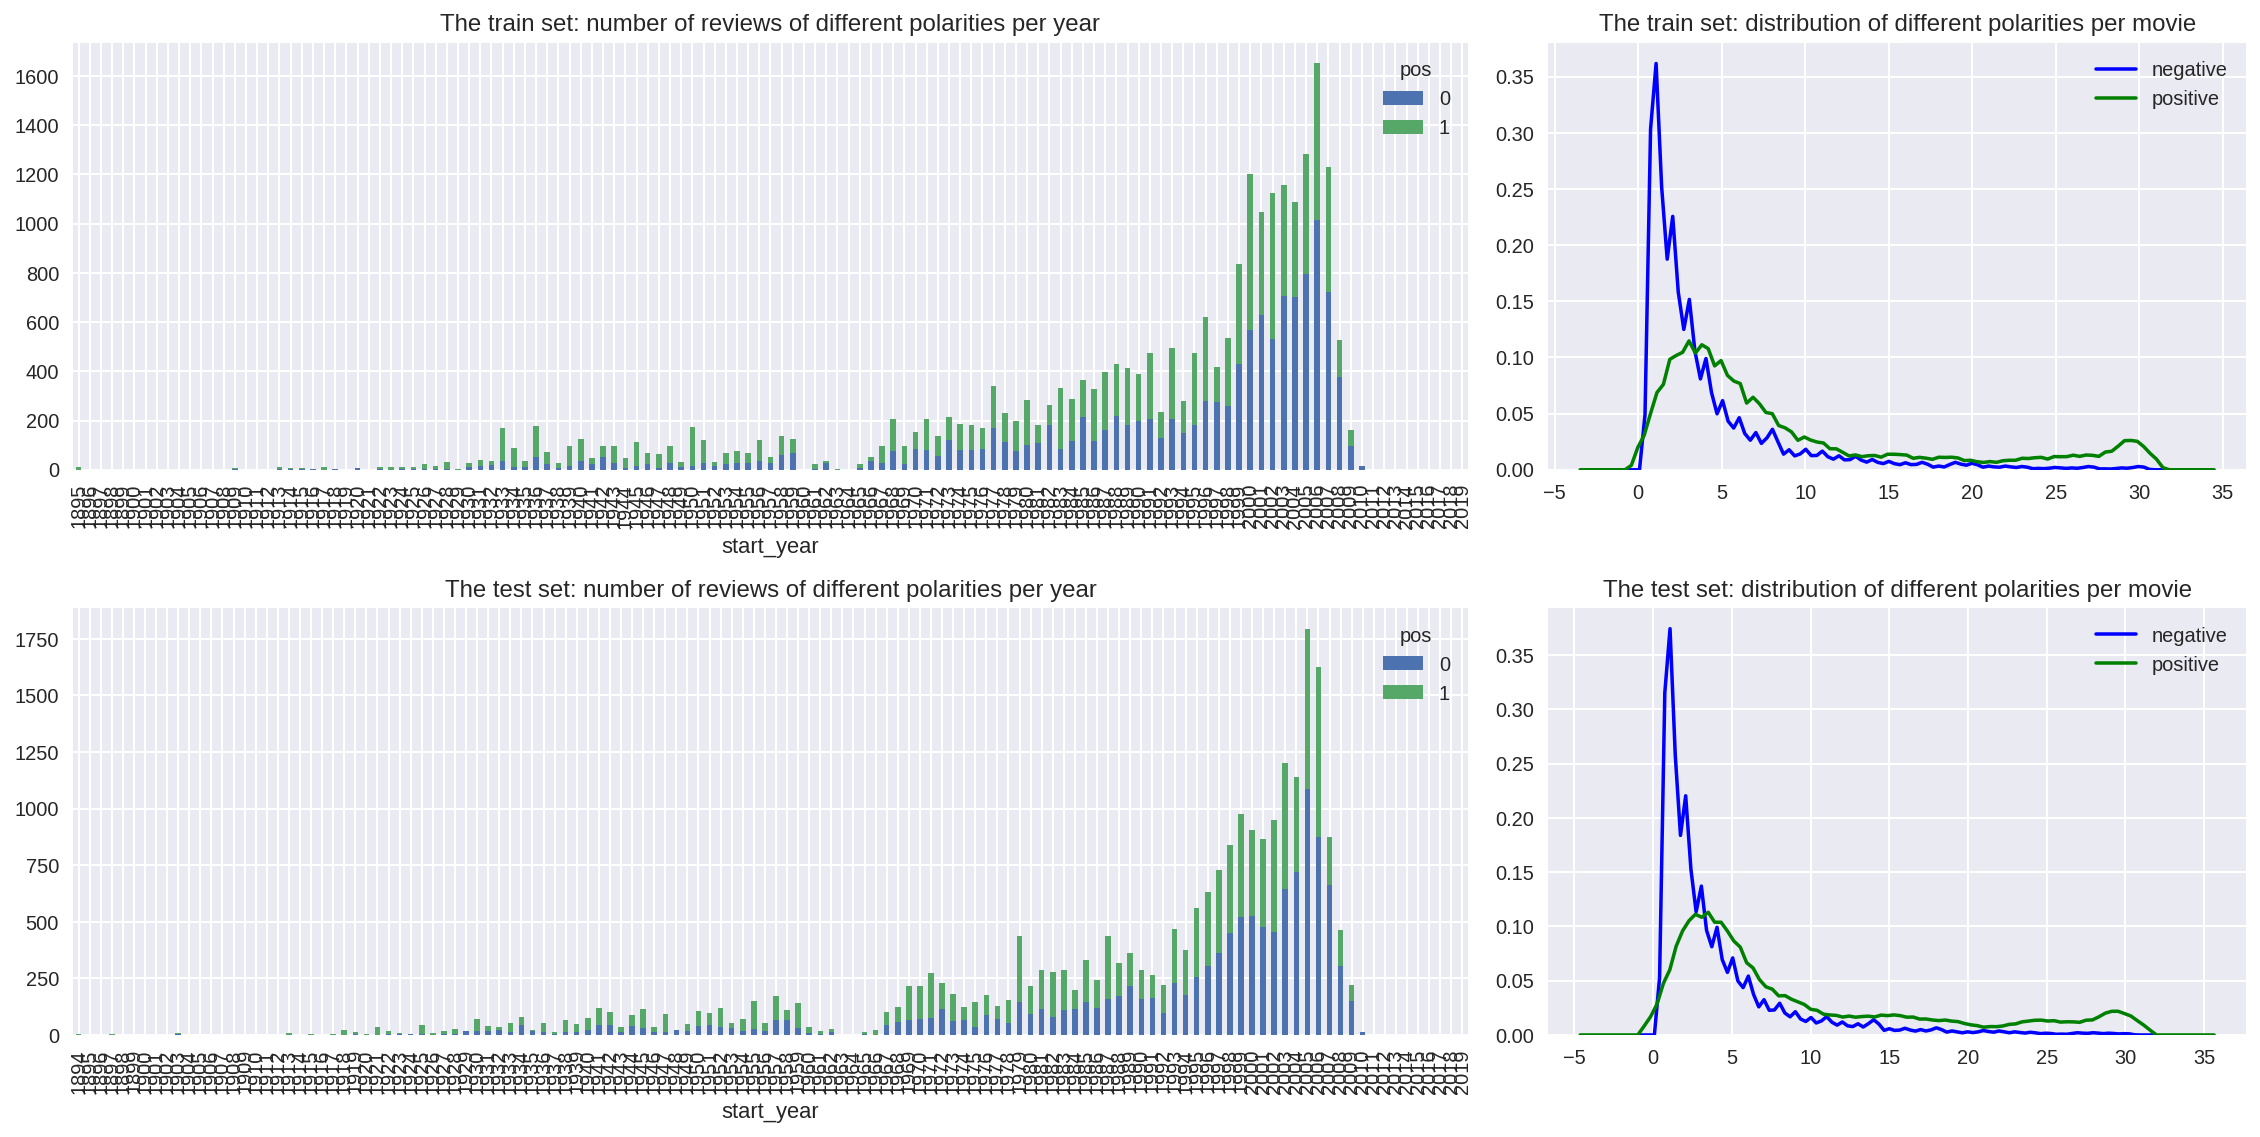

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The distribution of negative and positive reviews per year of the test and train set are about the same.

**Conclusion**

We analyzed the reviews per year and the movies per year. The number of movies per year is about the same as the reviews per year. We saw the distribution of ratings in both the training and testing set are about the same. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
def clear_text(text):
    
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = " ".join(text.split())
    return text.lower()#< write code here >


In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)# <put your code here>

In [18]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i'm totally agree with garryjohal from singapo...


We normalize the data to make it easier to work with.

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


We split the normalized data in to a train and test set.

## Working with models

### Model 0 - Constant

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
dummy_model = DummyClassifier()

In [22]:
%%time

dummy_model.fit(train_features, train_target)

CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 1.69 ms


DummyClassifier(constant=None, random_state=None, strategy='stratified')

          train  test
Accuracy   0.50  0.50
F1         0.51  0.50
APS        0.50  0.50
ROC AUC    0.50  0.49


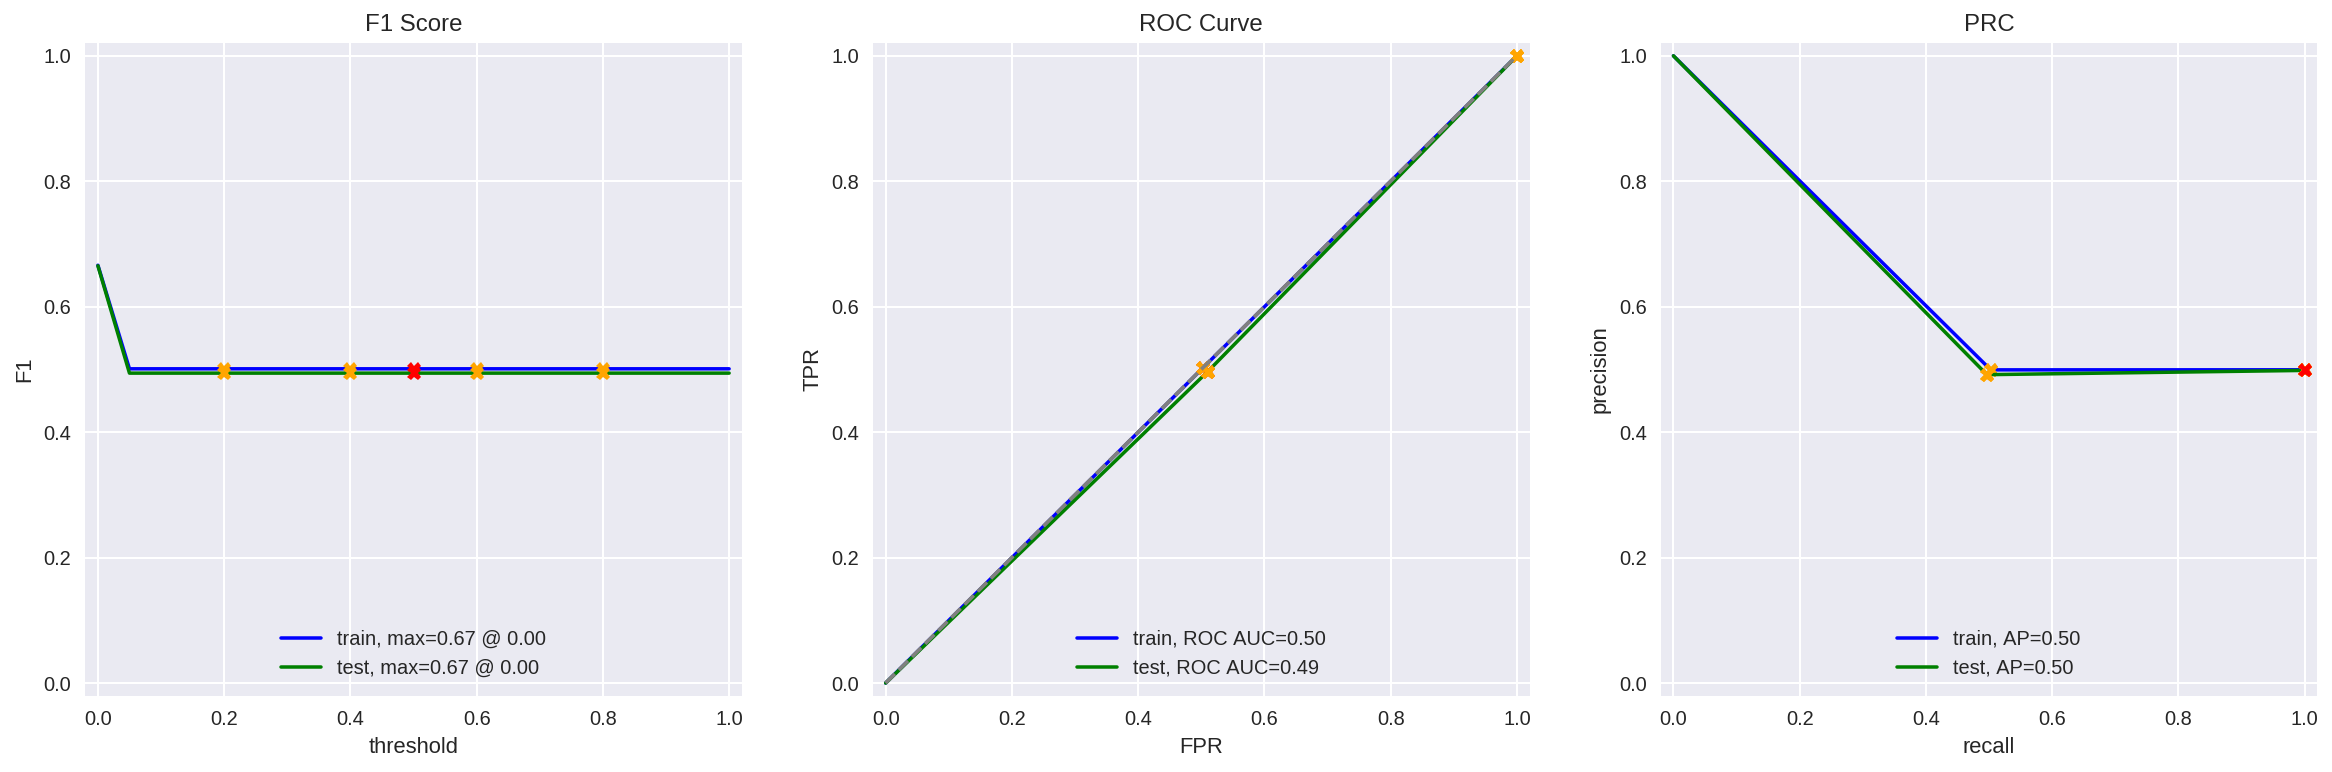

In [23]:
evaluate_model(dummy_model, train_features, train_target, test_features, test_target)

We used a dummy classifier as our baseline. The accuracy is 50% and the F1 score is 0.5.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [25]:
def lemmatize_nltk(text):
    lemmatizer  = WordNetLemmatizer() # create a lemmatization object
    tokens = word_tokenize(text.lower()) # split text into tokens
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    lemmatized = " ".join(lemmas) 
    return lemmatized

In [26]:
df_reviews_train['review_nltk'] = train_features.apply(lemmatize_nltk)
df_reviews_test['review_nltk'] = test_features.apply(lemmatize_nltk)

In [27]:
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = stop_words)

train_corpus_nltk = df_reviews_train['review_nltk']
train_nltk_tf_idf = count_tf_idf.fit_transform(train_corpus_nltk)

test_corpus_nltk = df_reviews_test['review_nltk']
test_nltk_tf_idf = count_tf_idf.transform(test_corpus_nltk)

In [28]:
%%time

lr_nltk_model = LogisticRegression(random_state = 123, solver = 'liblinear')

lr_nltk_model.fit(train_nltk_tf_idf,train_target)

CPU times: user 4.39 s, sys: 3.61 s, total: 8 s
Wall time: 8.01 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


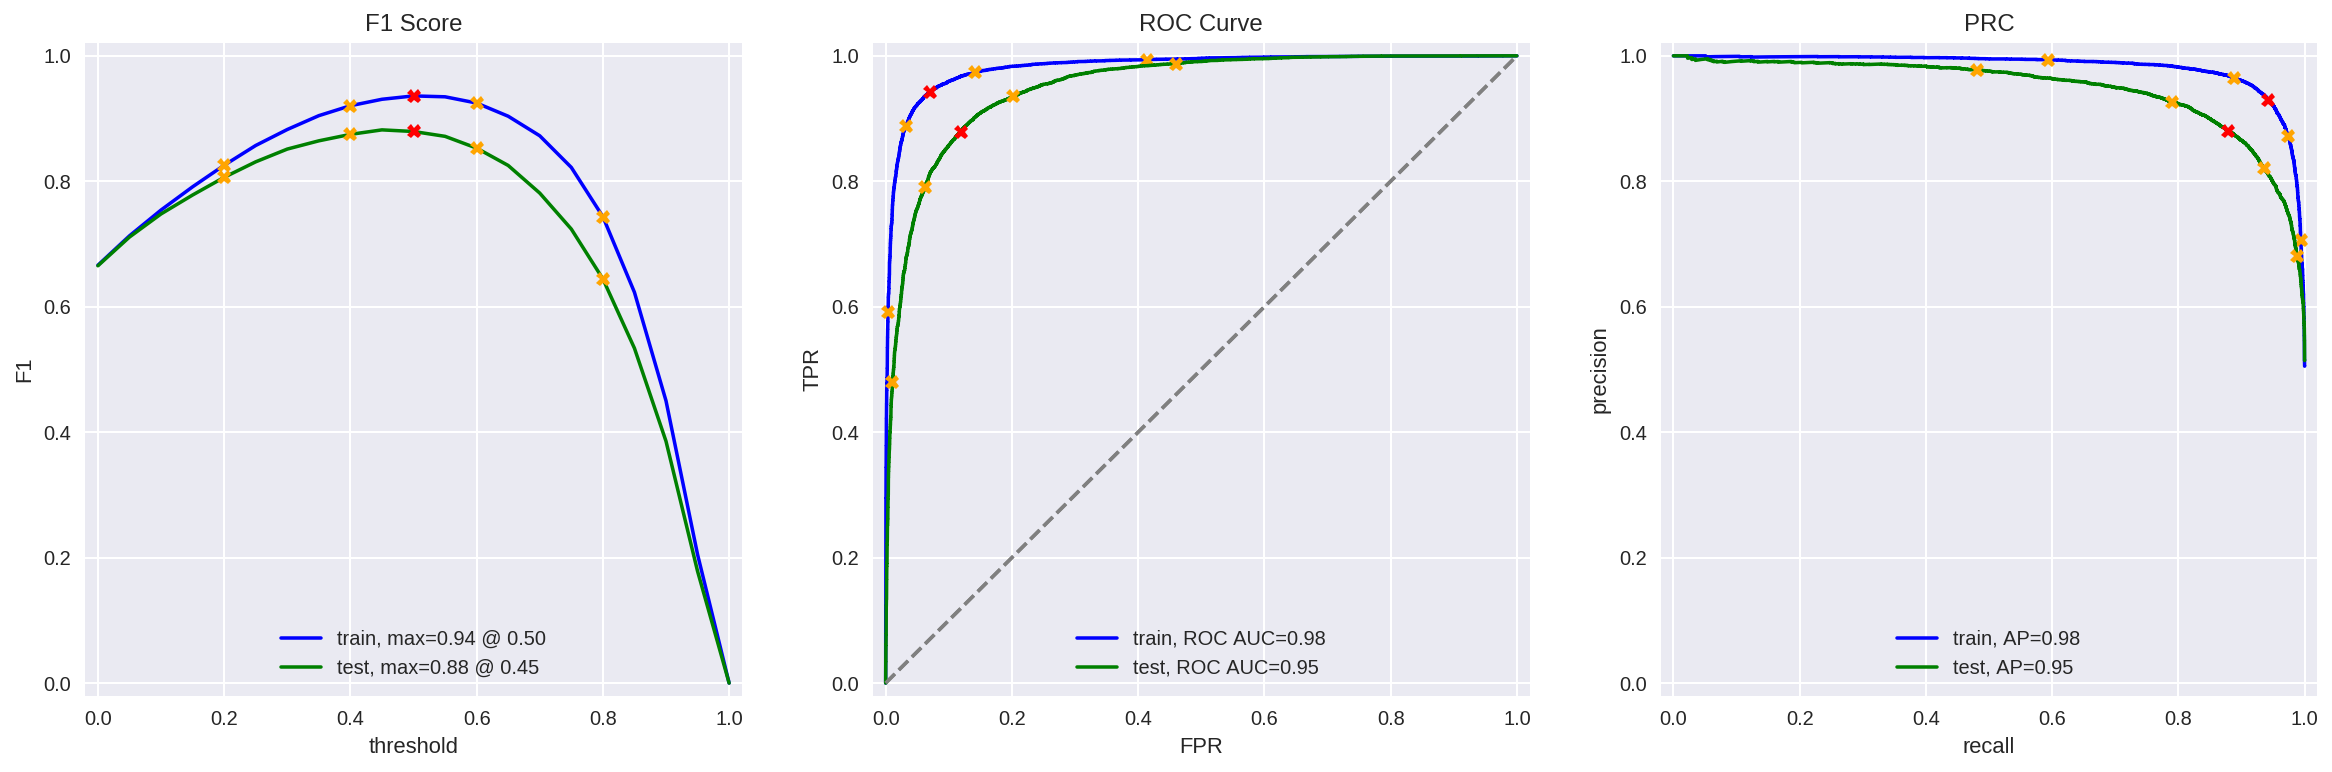

In [29]:
evaluate_model(lr_nltk_model, train_nltk_tf_idf, train_target, test_nltk_tf_idf, test_target)

We used logistic regression with NLTK preprocessing and achieved a F1 score of 88%

### Model 2 - spaCy, TF-IDF and LR

In [30]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
def text_preprocessing_3(text):
    
    doc = nlp(text.lower())
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [32]:
df_reviews_train['review_spacy'] = train_features.apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = test_features.apply(text_preprocessing_3)

In [33]:
train_corpus_spacy = df_reviews_train['review_spacy']
train_spacy_tf_idf = count_tf_idf.fit_transform(train_corpus_spacy)

test_corpus_spacy = df_reviews_test['review_spacy']
test_spacy_tf_idf = count_tf_idf.transform(test_corpus_spacy)

In [34]:
%%time

lr_spacy_model = LogisticRegression(random_state = 123, solver = 'liblinear')

lr_spacy_model.fit(train_spacy_tf_idf,train_target)

CPU times: user 5.11 s, sys: 4.18 s, total: 9.3 s
Wall time: 9.3 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


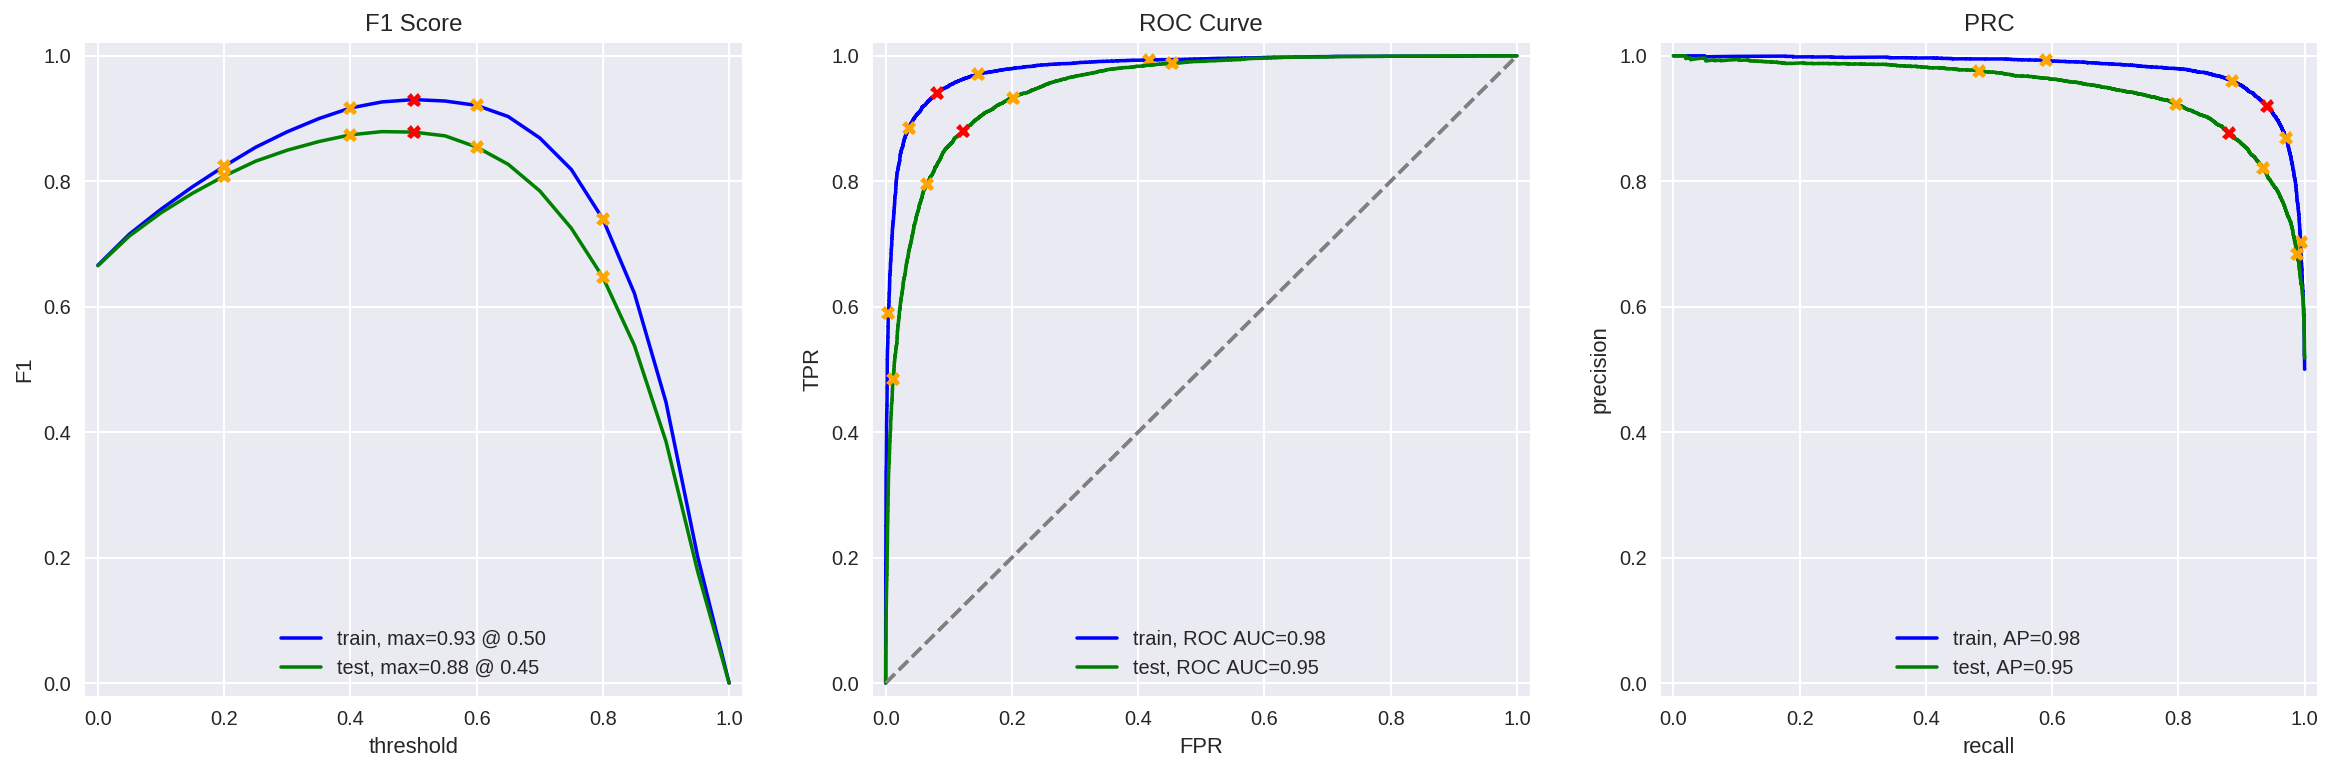

In [35]:
evaluate_model(lr_spacy_model, train_spacy_tf_idf, train_target, test_spacy_tf_idf, test_target)

We obtained a F1 score of 88% on the test set when using the logistic regression with spaCy preprocessing.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

In [37]:
%%time

lgbm_spacy_model = LGBMClassifier(random_state = 123)

lgbm_spacy_model.fit(train_spacy_tf_idf,train_target)

CPU times: user 2min 22s, sys: 727 ms, total: 2min 23s
Wall time: 2min 24s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


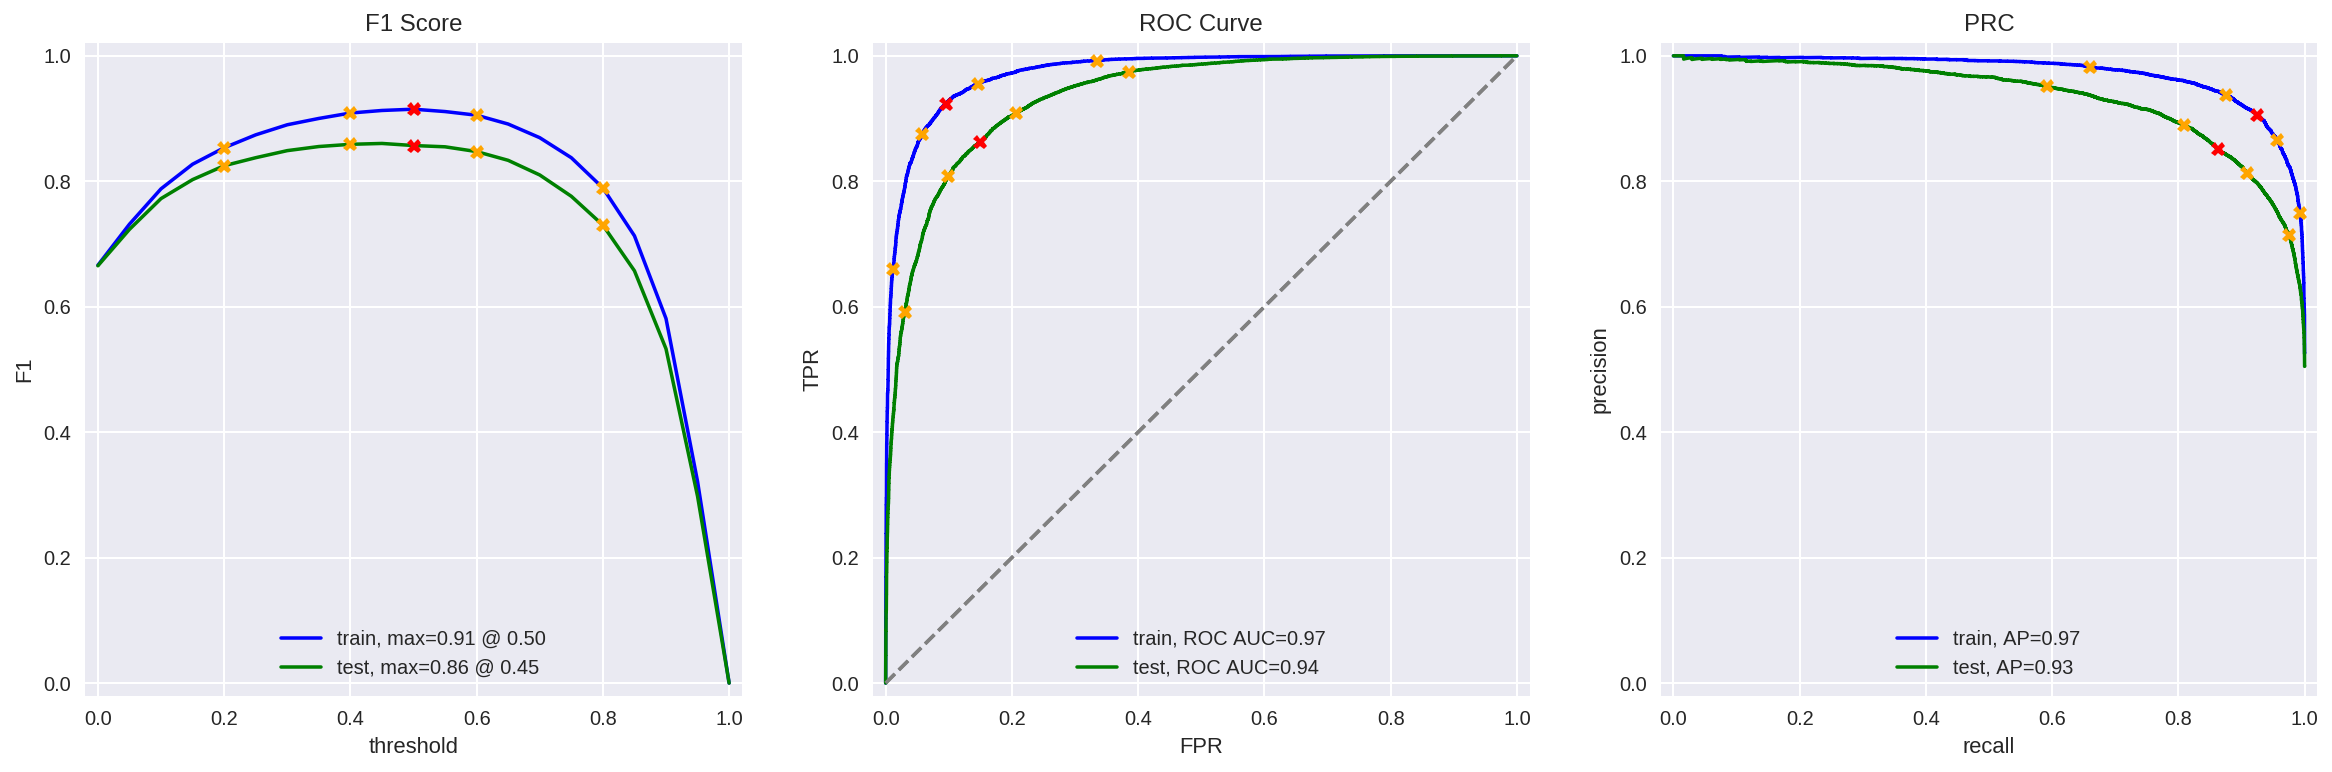

In [38]:
evaluate_model(lgbm_spacy_model, train_spacy_tf_idf, train_target, test_spacy_tf_idf, test_target)

From the lightGBM classifier with spaCy preprocessing, we obtained a F1 score of 86%

### Model 4 - spaCy, TF-IDF and XGBoostClassifier

In [39]:
from xgboost import XGBClassifier

In [40]:
%%time

xgb_spacy_model = XGBClassifier(random_state = 123)

xgb_spacy_model.fit(train_spacy_tf_idf,train_target)

CPU times: user 42.3 s, sys: 120 ms, total: 42.4 s
Wall time: 42.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.82  0.81
F1         0.83  0.82
APS        0.91  0.89
ROC AUC    0.91  0.90


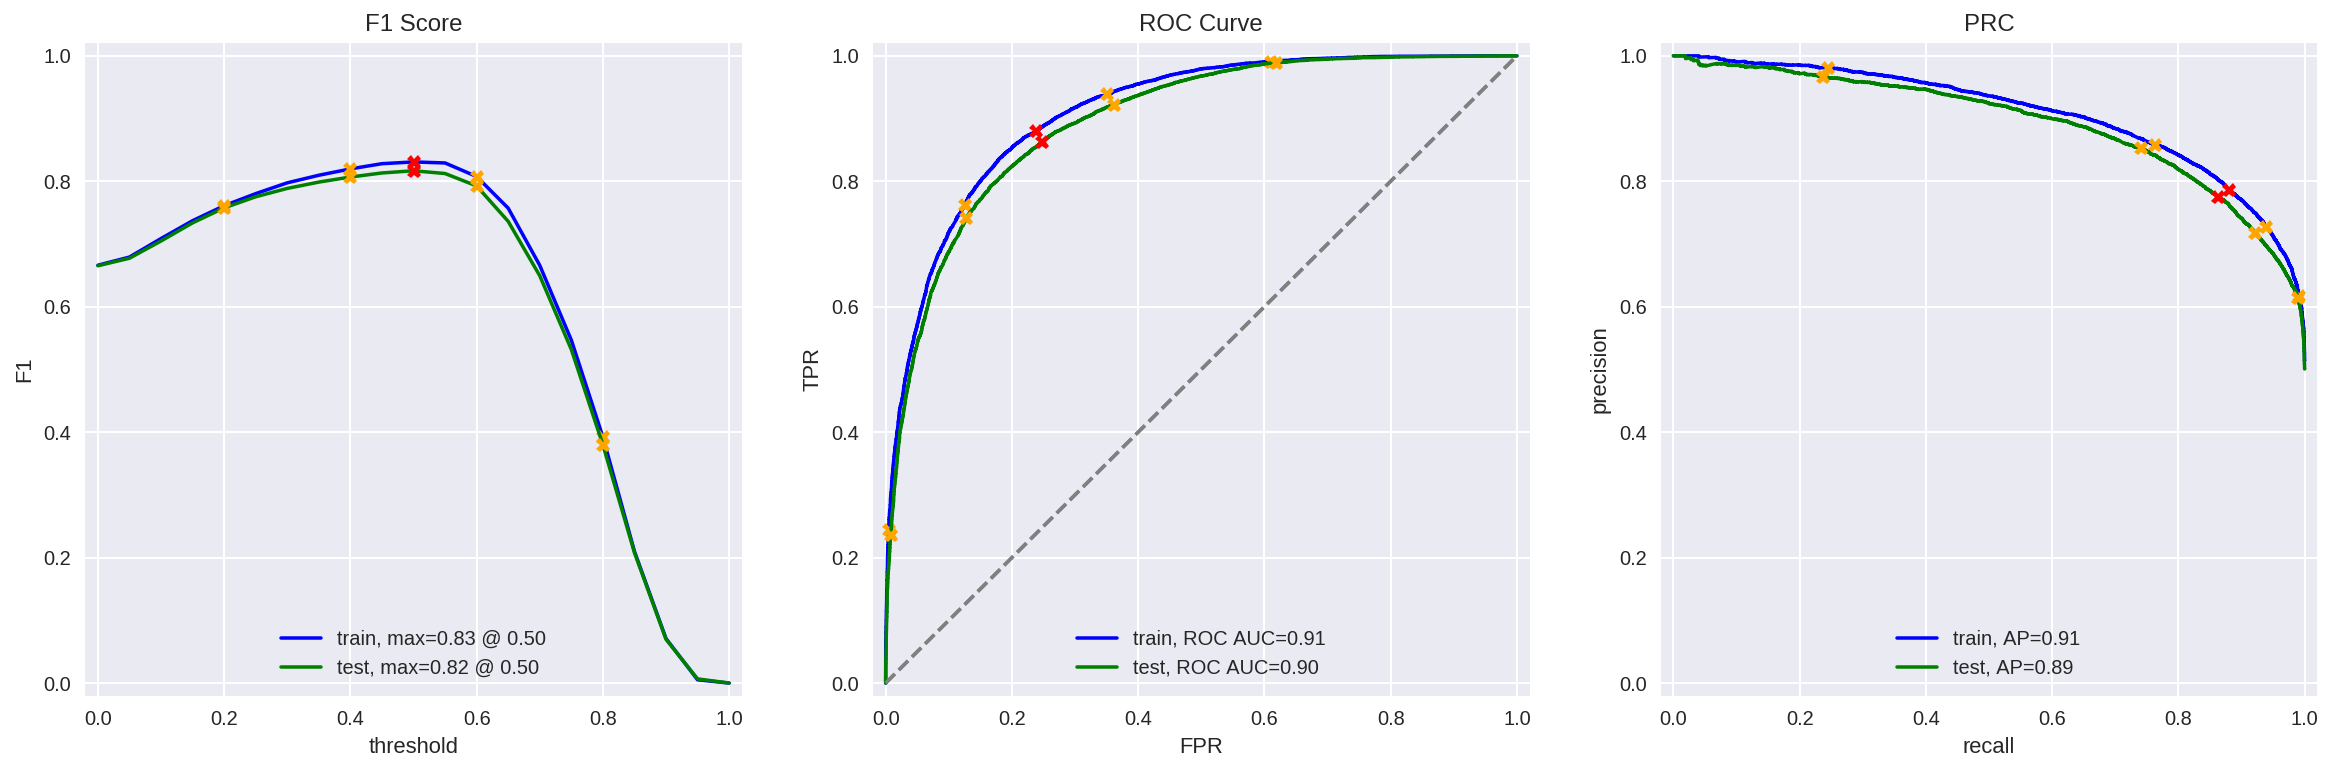

In [41]:
evaluate_model(xgb_spacy_model, train_spacy_tf_idf, train_target, test_spacy_tf_idf, test_target)

The xgboost classifier achieved a low F1 score of 82%. This is not a high enough F1 score to pass the projects threshold of 85%.

**Conclusion**

Based on our models, the best model for training is the logistic regressor. The model obtained a F1 score of 88% for both preprocessing with NLTK and spaCy. The lightGBM model achieved a score of 86% but took the longest to train. XGboost classification did not obtain a high enough F1 score to pass the projects threshold.

## My Reviews

In [42]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)# <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2 - spaCy, TF-IDF and LR

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred = lr_spacy_model.predict(count_tf_idf.transform(texts))
my_reviews_pred_prob = lr_spacy_model.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

print('Pos:'+'  '+'Probabilities:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f' {my_reviews_pred[i]}:       {my_reviews_pred_prob[i]:.2f}:        {review}')

Pos:  Probabilities:  Review:
 0:       0.27:        i did not simply like it not my kind of movie
 0:       0.08:        well i was bored and felt asleep in the middle of the movie
 0:       0.44:        i was really fascinated with the movie
 0:       0.11:        even the actors looked really old and disinterested and they got paid to be in the movie what a soul
 0:       0.24:        i didn't expect the reboot to be so good writers really cared about the source material
 0:       0.54:        the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
 0:       0.02:        what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
 1:       0.91:        launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The logistic regressor model predicted one positive out of eight reviews.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred = lgbm_spacy_model.predict(count_tf_idf.transform(texts))
my_reviews_pred_prob = lgbm_spacy_model.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

print('Pos:'+'  '+'Probabilities:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f' {my_reviews_pred[i]}:       {my_reviews_pred_prob[i]:.2f}:         {review}')

Pos:  Probabilities:  Review:
 1:       0.63:         i did not simply like it not my kind of movie
 0:       0.18:         well i was bored and felt asleep in the middle of the movie
 1:       0.60:         i was really fascinated with the movie
 0:       0.36:         even the actors looked really old and disinterested and they got paid to be in the movie what a soul
 1:       0.66:         i didn't expect the reboot to be so good writers really cared about the source material
 1:       0.68:         the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
 0:       0.26:         what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
 1:       0.75:         launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The lightGBM classifier predicted five positive out of eight reviews.

### Model 4 - spaCy, TF-IDF and XGBoostClassifier

In [45]:
texts = my_reviews['review_norm']

my_reviews_pred = xgb_spacy_model.predict(count_tf_idf.transform(texts))
my_reviews_pred_prob = xgb_spacy_model.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

print('Pos:'+'  '+'Probabilities:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f' {my_reviews_pred[i]}:       {my_reviews_pred_prob[i]:.2f}:         {review}')

Pos:  Probabilities:  Review:
 1:       0.61:         i did not simply like it not my kind of movie
 1:       0.57:         well i was bored and felt asleep in the middle of the movie
 1:       0.61:         i was really fascinated with the movie
 1:       0.56:         even the actors looked really old and disinterested and they got paid to be in the movie what a soul
 1:       0.66:         i didn't expect the reboot to be so good writers really cared about the source material
 1:       0.61:         the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
 0:       0.50:         what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
 1:       0.61:         launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The XGboost classifier predicted seven positive out of eight reviews.

**Conclusion**

We classified four positive reviews and four negative reviews with our models. The logistic regression model classified one review as positive and seven reviews as negative, while the XGboost classifier achieved seven reviews as positive and one as negative. Both models are not working as they should. The lightGBM classifier performed best by obtaining five positive reviews and 3 negative reviews. 

## Conclusions

Our data consisted of 47331 entries and 17 columns. We removed missing values and there were no duplicate rows. Through EDA we saw the distribution of ratings in both the training and testing set are about the same. We developed an evaluation routine which can be used for all models in this project. The data was normalized and split in to a train and test set.

The models we worked with were logistic regression with NLTK and spaCy preprocessing, lightGBM classifier with spaCy, and XGboost classifier with spaCy. The accuracy produced from our baseline was 50% and the F1 score is 0.5. We obtained a F1 score of 88% from the logistic regression with NLTK and spaCy preprocessing. The lightGBM classifier wth spaCy preprocessing obtained a F1 score of 86%. The xgboost classifier with spaCy achieved a F1 score of 82%. 

Both the linear regression and XGboost classifier algorithms did not preform well when classifying reviews. The lightGBM classifier performed best by classifying five positive reviews out of eight. The best model for the task of detecting negative reviews is the lightGBM algorithm.

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions